# Prepare Dataset

loading in the new dataset

In [1]:
import os
import pandas as pd
import torch
from tqdm import tqdm
import numpy as np
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
#os.chdir('src')

RDKit WARNING: [12:50:49] Enabling RDKit 2020.03.1dev1 jupyter extensions


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
os.chdir('src')
from featurization.data_utils import load_data_from_df, construct_loader

In [4]:
#batch_size=64
X,y = load_data_from_df('../data/aqsol/aqsol.csv',one_hot_formal_charge=True)
#data_loader=construct_loader(X,y,batch_size)

In [5]:
batch_size=8
data_loader=construct_loader(X,y,batch_size)

# Prepare Model

In [6]:
from transformer import make_model

In [7]:
d_atom = X[0][0].shape[1]  # It depends on the used featurization.

model_params = {
    'd_atom': d_atom,
    'd_model': 1024,
    'N': 8,
    'h': 16,
    'N_dense': 1,
    'lambda_attention': 0.33, 
    'lambda_distance': 0.33,
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'distance_matrix_kernel': 'exp', 
    'dropout': 0.0,
    'aggregation_type': 'mean'
}

model = make_model(**model_params)

# Load Pretrained weights

In [ ]:
pretrained_name = '../pretrained_weights.pt'  # This file should be downloaded first (See README.md).
pretrained_state_dict = torch.load(pretrained_name)

In [ ]:
model_state_dict = model.state_dict()
for name, param in pretrained_state_dict.items():
    if 'generator' in name:
         continue
    if isinstance(param, torch.nn.Parameter):
        param = param.data
    model_state_dict[name].copy_(param)

# Running Training/Evaluation Loops

In [ ]:
#first we will try a basic MSE loss with SGD to test the fit

#targets to beat
#  Full regression - R^2=0.7325, RMS=1.2248 (pls/ridge)
#               CV - R^2=0.5922, RMS=1.5130 (elastic)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.cuda()
criterion=torch.nn.MSELoss(reduction='mean')
optimizer=torch.optim.SGD(model.parameters(),lr=1e-4,momentum=0.9)

losses=[]
#initial test -- guess at seeing the training 500times
model.train()
for epoch in tqdm(range(50)):
    for batch in data_loader:
        adjacency_matrix, node_features, distance_matrix, y = batch
        batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
        y_pred = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)
        
        
        loss=criterion(y_pred,y)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
plt.plot(losses)

In [ ]:
epoch_mean_losses=[]
for i in range(int(len(losses)/len(data_loader))):
    tmp=[]
    for j in range(int(len(data_loader))):
        tmp.append(losses[int(j+i*len(losses)/len(data_loader))])
    epoch_mean_losses.append(np.mean(tmp))

In [ ]:
plt.plot(epoch_mean_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss -- Fitting to whole dataset')

In [ ]:
plt.plot([x for x in range(400,500)],epoch_mean_losses[-100:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss -- last 100 epochs')

In [ ]:
#post-training we need predictions to calculate the R^2 and RMS
gold=np.array([])
preds=np.array([])
model.eval()
for batch in data_loader:
    adjacency_matrix, node_features, distance_matrix, y = batch
    gold=np.append(gold,y.tolist())
    batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
    y_pred = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)
    preds=np.append(preds,y_pred.tolist())

#TODO -- implement R^2 and RMS between gold and preds (after figuring out what type of thing they are...)

In [ ]:
np.corrcoef(preds,gold)[0][1]**2

In [ ]:
np.sqrt(np.mean(preds-gold)**2)

In [ ]:
#saving the model
torch.save(model.state_dict(),'../aqsol_fit.pt')

# Initial fit looked promising!

Now we need to generate two different CV splits of the data -- random & scaffold

In [ ]:
#first we are doing the random split

from sklearn.model_selection import ShuffleSplit
rs=ShuffleSplit(n_splits=3, test_size=1/3.0,random_state=0)

X=pd.read_csv('../data/aqsol/aqsol.csv')

lines=open('../data/aqsol/aqsol.csv').readlines()
lines=lines[1:]

for i,(train_index,test_index) in enumerate(rs.split(X)):
    with open('../data/aqsol/aqsol_rand_train'+str(i)+'.csv','w') as outfile:
        outfile.write('smiles,y\n')
        for ind in train_index:
            outfile.write(lines[ind])
    with open('../data/aqsol/aqsol_rand_test'+str(i)+'.csv','w') as outfile:
        outfile.write('smiles,y\n')
        for ind in test_index:
            outfile.write(lines[ind])

In [12]:
#now we will do a scaffold-split

#first we need to generate a scaffolds dictionary
scaffolds={}
from rdkit.Chem.Scaffolds import MurckoScaffold
X=pd.read_csv('../data/aqsol/aqsol.csv')
smis=X['smiles']

for i,s in enumerate(smis):
    mol=Chem.MolFromSmiles(s)
    scaffold=MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
    
    if scaffold not in scaffolds:
        scaffolds[scaffold]=[i]
    else:
        scaffolds[scaffold].append(i)

scaffolds={key: sorted(value) for key,value in scaffolds.items()}

RDKit WARNING: [10:22:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:22:08] WARNING: not r

In [30]:
#generating a plot of similarities between scaffolds
scaffold_fps=[Chem.MolFromSmiles(x) for x in scaffolds.keys()]

scaffold_fps=[x for x in scaffold_fps if x is not None] #removes the group which has no scaffold
scaffold_fps=[Chem.GetMorganFingerprintAsBitVect(x,2,1024) for x in scaffold_fps]

sims=[]
for i in range(1,len(scaffold_fps)):
    sim=DataStructs.BulkTanimotoSimilarity(scaffold_fps[i],scaffold_fps)
    sims.append(sim)

In [31]:
len(sims),len(scaffold_fps)

(1945, 1946)

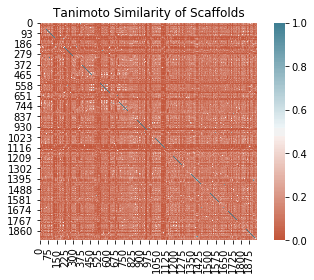

In [36]:
#slow to save PDF, png much faster
fig=plt.figure()
sns.heatmap(sims,vmin=0,vmax=1,center=0.5,cmap=sns.diverging_palette(20,220,n=200),square=True)
plt.title('Tanimoto Similarity of Scaffolds')
plt.savefig('../tanimoto_aqsol_scaffolds.png',dpi=200)
plt.show()

In [ ]:
#generate a list of the ids and randomize it
scaffold_sets=[scaffold_set for (scaffold,scaffold_set) in sorted(scaffolds.items(),key=lambda x: (len(x[1]),x[1][0]),reverse=True)]
random.shuffle(scaffold_sets)

n_samples=np.sum([len(x) for x in scaffold_sets]
#setting the size cutoff for the training set
cutoff=1/3.0*n_samples)

#splitting the ids -- these will have the index of the line in each set
fold_0, fold_1, fold_2=[],[],[]

for i in range(len(scaffold_sets)):
    ids=scaffold_sets.pop()
    if len(fold_0)+len(ids)>cutoff:
        #add to fold 1 or 2
        if len(fold_1)+len(ids)>cutoff:
            #add to fold2
            fold_2+=ids
        else:
            #add to fold1
            fold_1+=ids
    else:
        fold_0+=ids

assert(len(fold_0)+len(fold_1)+len(fold_2)==n_samples)

for fold in ['0','1','2']:
    with open('../data/aqsol/aqsol_scaf_train'+str(fold)+'.csv','w') as outfile:
        outfile.write('smiles,y\n')
        if fold=='0':
            for idx in fold_1:
                outfile.write(lines[idx])
            for idx in fold_2:
                outfile.write(lines[idx])
        elif fold=='1':
            for idx in fold_0:
                outfile.write(lines[idx])
            for idx in fold_2:
                outfile.write(lines[idx])
        else:
            for idx in fold_0:
                outfile.write(lines[idx])
            for idx in fold_1:
                outfile.write(lines[idx])
    
    with open('../data/aqsol/aqsol_scaf_test'+str(fold)+'.csv','w') as outfile:
        outfile.write('smiles,y\n')
        if fold=='0':
            for idx in fold_0:
                outfile.write(lines[idx])
            
        elif fold=='1':
            for idx in fold_1:
                outfile.write(lines[idx])
            
        else:
            for idx in fold_2:
                outfile.write(lines[idx])

## looking at interfold Scaffold sim & intrafold scaffold sim

In [50]:
scaffolds={}#dic of fold:<train|test>:set(scaffolds)
from rdkit.Chem.Scaffolds import MurckoScaffold

for fold in ['0','1','2']:
    scaffolds[fold]={'train':set(),'test':set()}
    
    for item in ['train','test']:
        X=pd.read_csv(f'data/aqsol/aqsol_scaf_{item}{fold}.csv')
        smis=X['smiles']
        
        for i,s in enumerate(smis):
            mol=Chem.MolFromSmiles(s)
            scaffold=MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
            scaffolds[fold][item].add(scaffold)

RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:13] WARNING: not r

RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:08:18] WARNING: not r

In [29]:
def generate_similarities(list1,list2):
    l1_fps=[Chem.MolFromSmiles(x) for x in list1]
    l1_fps=[x for x in l1_fps if x is not None] #removes the group which has no scaffold
    l1_fps=[Chem.GetMorganFingerprintAsBitVect(x,2,1024) for x in l1_fps]
    
    l2_fps=[Chem.MolFromSmiles(x) for x in list2]
    l2_fps=[x for x in l2_fps if x is not None] #removes the group which has no scaffold
    l2_fps=[Chem.GetMorganFingerprintAsBitVect(x,2,1024) for x in l2_fps]
    
    l1_sim=[]
    l2_sim=[]
    l1_l2_sim=[]
    
    for i in range(len(l1_fps)):
        sim=DataStructs.BulkTanimotoSimilarity(l1_fps[i],l1_fps)
        l1_sim.append(sim)
    
    for i in range(len(l2_fps)):
        sim=DataStructs.BulkTanimotoSimilarity(l2_fps[i],l2_fps)
        l2_sim.append(sim)
        
        sim=DataStructs.BulkTanimotoSimilarity(l2_fps[i],l1_fps)
        l1_l2_sim.append(sim)
    
    return l1_sim, l2_sim, l1_l2_sim

In [86]:
def plotter(data, filename,title,is_square=True,vmin=0,vmax=1):
    fig=plt.figure()
    sns.heatmap(data,vmin=vmin,vmax=vmax,cmap=sns.color_palette("RdBu_r",70),center=(vmin+vmax)/2.0,square=is_square)
    plt.title(title)
    plt.savefig(filename,dpi=200)
    plt.show()

RDKit ERROR: [14:12:31] Can't kekulize mol.  Unkekulized atoms: 2 6 7
RDKit ERROR: 
RDKit ERROR: [14:12:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit ERROR: 


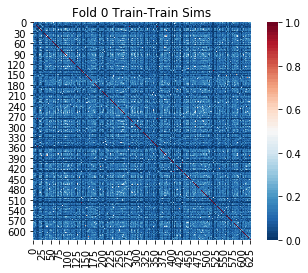

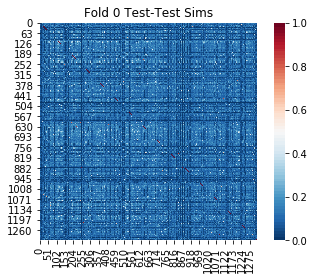

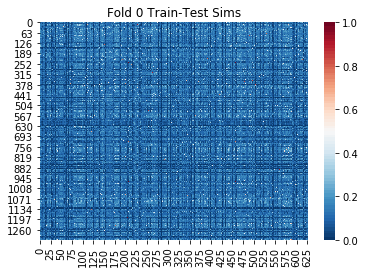

RDKit ERROR: [14:12:40] Can't kekulize mol.  Unkekulized atoms: 2 6 7
RDKit ERROR: 
RDKit ERROR: [14:12:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit ERROR: 


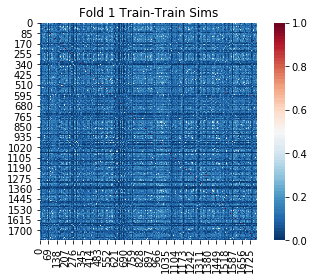

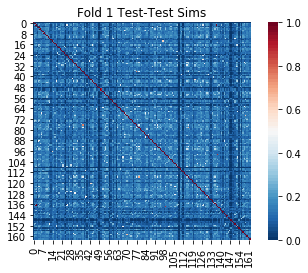

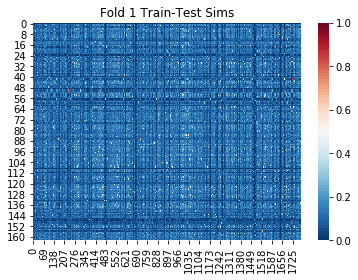

RDKit ERROR: [14:12:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit ERROR: 
RDKit ERROR: [14:12:49] Can't kekulize mol.  Unkekulized atoms: 2 6 7
RDKit ERROR: 


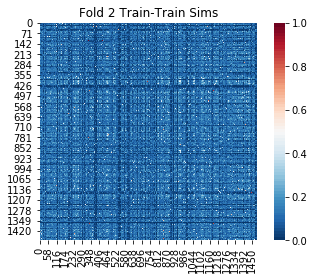

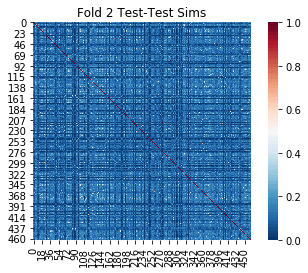

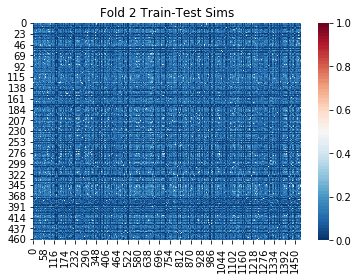

In [55]:
#generating a plot of similarities between scaffolds
for fold in ['0','1','2']:
    ta,tb,tc=generate_similarities(scaffolds[fold]['train'],scaffolds[fold]['test'])
    
    plotter(ta,f'aqsol_scaf_{fold}_train_scafsims.png',f'Fold {fold} Train-Train Sims')
    plotter(tb,f'aqsol_scaf_{fold}_test_scafsims.png',f'Fold {fold} Test-Test Sims')
    plotter(tc,f'aqsol_scaf_{fold}_traintest_scafsims.png',f'Fold {fold} Train-Test Sims',False)

In [58]:
#that was inconclusive, now I'll look at whole molecule similarities
smiles={}#dic of fold:<train|test>:[smiles]

for fold in ['0','1','2']:
    smiles[fold]={'train':[],'test':[]}
    
    for item in ['train','test']:
        X=pd.read_csv(f'data/aqsol/aqsol_scaf_{item}{fold}.csv')
        smis=X['smiles']
        
        for i,s in enumerate(smis):
            smiles[fold][item].append(s)

RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:17] WARNING: not r

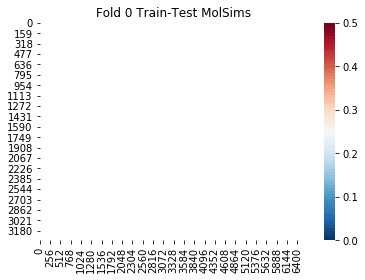

RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:05] WARNING: not r

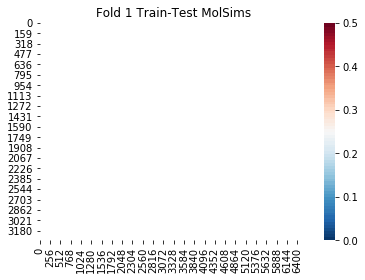

RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:28:53] WARNING: not r

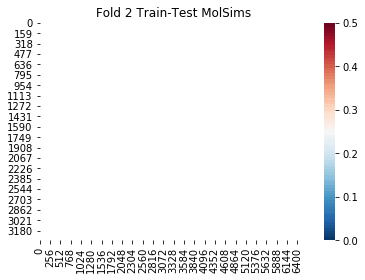

In [88]:
for fold in ['0','1','2']:
    ta,tb,tc=generate_similarities(smiles[fold]['train'],smiles[fold]['test'])
    
    #plotter(ta,f'aqsol_scaf_{fold}_train_molsims.png',f'Fold {fold} Train-Train MolSims')
    #plotter(tb,f'aqsol_scaf_{fold}_test_molsims.png',f'Fold {fold} Test-Test MolSims')
    plotter(tc,f'aqsol_scaf_{fold}_traintest_molsims.png',f'Fold {fold} Train-Test MolSims',False,0,0.5)

# Next bit

In [10]:
#now with all of the files created, we need to save the pickle of the things...
#attempt number1 will use multiprocessing to perform this task
import glob
from multiprocessing import Pool

In [11]:
def helper(fname):
    X,y = load_data_from_df(fname,one_hot_formal_charge=True,two_d_only=True)
    return((X,y))

In [12]:
todo=glob.glob('/home/paf46/git/MAT/data/aqsol/aqsol*2d*_t*.csv')

In [14]:
todo.sort()
todo

['/home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test0.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test1.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test2.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train0.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train1.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train2.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_test0.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_test1.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_test2.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_train0.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_train1.csv',
 '/home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_train2.csv']

In [18]:
_=helper(todo[0])

RDKit WARNING: [14:45:49] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:49] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:49] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:49] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:51] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:45:51] WARNING: not r

In [30]:
!ls -lh /home/paf46/git/MAT/data/aqsol/*2d*.p

-rw-rw-r-- 1 paf46 paf46 40M Mar 24 14:45 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test0_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46 40M Mar 24 14:49 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test1_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46 40M Mar 24 14:50 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test2_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46 77M Mar 24 14:50 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train0_dn_ohfc.p


In [32]:
!wc /home/paf46/git/MAT/data/aqsol/*.csv | grep -v 2d

   9983    9983  441960 /home/paf46/git/MAT/data/aqsol/aqsol.csv
   3329    3329  147106 /home/paf46/git/MAT/data/aqsol/aqsol_rand_test0.csv
   3329    3329  147235 /home/paf46/git/MAT/data/aqsol/aqsol_rand_test1.csv
   3329    3329  147481 /home/paf46/git/MAT/data/aqsol/aqsol_rand_test2.csv
   6655    6655  294863 /home/paf46/git/MAT/data/aqsol/aqsol_rand_train0.csv
   6655    6655  294734 /home/paf46/git/MAT/data/aqsol/aqsol_rand_train1.csv
   6655    6655  294488 /home/paf46/git/MAT/data/aqsol/aqsol_rand_train2.csv
   3328    3328  176912 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_test0.csv
   3328    3328  123571 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_test1.csv
   3329    3329  141495 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_test2.csv
   6656    6656  265057 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_train0.csv
   6656    6656  318398 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_train1.csv
   6655    6655  300474 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_train2.csv
   1709    1709  

In [33]:
!wc /home/paf46/git/MAT/data/aqsol/*.csv | grep 2d

   9983    9983  441960 /home/paf46/git/MAT/data/aqsol/aqsol_2d.csv
   3329    3329  147106 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test0.csv
   3329    3329  147235 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test1.csv
   3329    3329  147481 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test2.csv
   6655    6655  294863 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train0.csv
   6655    6655  294734 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train1.csv
   6655    6655  294488 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train2.csv
   3328    3328  176912 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_test0.csv
   3328    3328  123571 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_test1.csv
   3329    3329  141495 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_test2.csv
   6656    6656  265057 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_train0.csv
   6656    6656  318398 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_train1.csv
   6655    6655  300474 /home/paf46/git/MAT/data/aqsol/aqs

In [47]:
! ls -lh /home/paf46/git/MAT/data/aqsol/*.p | grep 2d

-rw-rw-r-- 1 paf46 paf46  40M Mar 24 14:45 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test0_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46  40M Mar 24 14:49 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test1_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46  40M Mar 24 14:50 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_test2_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46  77M Mar 24 14:50 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train0_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46  76M Mar 24 15:04 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train1_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46  77M Mar 24 15:04 /home/paf46/git/MAT/data/aqsol/aqsol_rand_2d_train2_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46  52M Mar 24 15:05 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_test0_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46  28M Mar 24 15:05 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_test1_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46  37M Mar 24 15:05 /home/paf46/git/MAT/data/aqsol/aqsol_scaf_2d_test2_dn_ohfc.p
-rw-rw-r-- 1 paf46 paf46  64M Mar 24 15:05 /home/paf46/git/MA

# Code for measuring inference

In [8]:
import time
from featurization.data_utils import load_data_from_smiles
import random

In [9]:
def complex_measure(model,list_of_smiles):
    '''
    A more complicated measure of the forward-pass.
    
    This function takes in a list of smile strings, then will create the needed molecular graphs & run the forward-pass
    
    Assumes the model is in evaluate mode
    '''
    t0=time.time()
    ls=[0.0 for x in list_of_smiles]
    t1=time.time()
    X,y=load_data_from_smiles(list_of_smiles,ls,add_dummy_node=True,one_hot_formal_charge=True)
    tload=time.time()-t1
    data_loader=construct_loader(X,y,1)
    for batch in data_loader:
        adjacency_matrix, node_features, distance_matrix, y = batch
        adjacency_matrix=adjacency_matrix.to('cpu')
        node_features=node_features.to('cpu')
        distance_matrix=distance_matrix.to('cpu')
        batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
        y_pred = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)
    elapsed_fp=time.time()-t0
    return elapsed_fp,tload

In [10]:
def get_mean_len(listo):
    lens=[len(x) for x in listo]
    return np.mean(lens)

In [11]:
#defining a cpu-version of the model
cpu_model = make_model(**model_params)
cpu_model.load_state_dict(torch.load('../aqsol_fit.pt',map_location='cpu'))

<All keys matched successfully>

### timing the forward pass when the model has structure loaded

In [12]:
#performing the timing
X,y = load_data_from_df('../data/aqsol/aqsol.csv',one_hot_formal_charge=True)
cpu_data_loader=construct_loader(X,y,batch_size)
times=[]
for batch in cpu_data_loader:
    adjacency_matrix, node_features, distance_matrix, y = batch
    batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
    batch_mask=batch_mask.to('cpu')
    adjacency_matrix=adjacency_matrix.to('cpu')
    node_features=node_features.to('cpu')
    distance_matrix=distance_matrix.to('cpu')
    y=y.to('cpu')
    t0=time.time()
    y_pred = cpu_model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)
    times.append((time.time()-t0)/float(batch_size))

In [13]:
len(times)

1248

In [14]:
np.mean(times)

0.02142225241718384

### Now we will do the timing when we have to go from smi -> graph -> forward pass

In [12]:
smis=open('../data/aqsol/aqsol.csv').readlines()

In [13]:
smis=[x.split(',')[0] for x in smis[1:]]

In [14]:
smis[0]

'[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C'

In [15]:
sorted_smis=sorted(smis,key=len)

In [21]:
random.shuffle(smis)

In [78]:
complex_measure(cpu_model,smis[:10])

(20.82856559753418, 20.486303329467773)

In [80]:
get_mean_len(smis[:10])

40.1

In [84]:
smis[:10]

['O.O.O.O.[Na+].[Na+].[O-]B([O-])[O-].[O-]B([O-])[O-].[O-]B([O-])[O-].[O-]B([O-])[O-].[O-]B([O-])[O-].[O-]B([O-])[O-].[O-]B([O-])[O-].[O-]B([O-])[O-]',
 'C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@H]34)[C@@H]1CC[C@@]2(O)C#C',
 'ClC(Cl)(Cl)C(Cl)(Cl)Cl',
 '[Na+].Nc1cc(cc(c1[O-])[N+]([O-])=O)[N+]([O-])=O',
 'CN1C(=O)N=CC2=C1NC(=O)N2',
 'Clc1ccc(cc1Cl)c2c(Cl)c(Cl)cc(Cl)c2Cl',
 'CCCCC(C)(C)O',
 'CCCCCCN',
 'OC(=O)c1occc1',
 'CC(C)C(=O)OC(C)(CCC=C(C)C)C=C']

In [79]:
complex_measure(cpu_model,smis[10:20])

(0.6705496311187744, 0.314424991607666)

In [85]:
smis[10:20]

['CCCCC(=O)N(C)C1=CC=C(C=C1)[S](=O)(=O)N(C)C',
 'CCCCC.CCc1ccccc1.Cc2ccccc2.Cc3cccc(C)c3.C4CCCC4',
 'CC1CCCC(=NO)C1=NO',
 'CC(=O)OC(C)(C)C1CCC(=CC1)C.CC23CCC(CC2)C(C)(C)O3',
 'CCOC1=CC=C(NC(=O)NC2=CC=C(OCC)C=C2)C=C1',
 'CC1=C(C=O)C(C)(C)CC=C1',
 'OC(C(O)=O)c1ccccc1',
 'CCC1CCCCC1',
 'CCC1OC(=O)c2cc(ccc12)[N+]([O-])=O',
 'COc1cc(Cl)c(OC)cc1Cl']

In [81]:
get_mean_len(smis[10:20])

29.6

In [82]:
complex_measure(cpu_model,smis[20:30])

RDKit ERROR: [23:55:55] UFFTYPER: Unrecognized atom type: Fe3 (0)
RDKit ERROR: [23:56:01] UFFTYPER: Unrecognized atom type: Fe3 (2)


(21.208584308624268, 20.822349548339844)

In [87]:
smis[20:30]

['OC[C@H]1OC2(COC3(CO2)O[C@H](CO)[C@@H](O)[C@@H]3O)[C@@H](O)[C@@H]1O',
 'Oc1ccc(cc1[N+]([O-])=O)C(F)(F)F',
 'CCC(=O)OCN1C(=O)NC(C1=O)(C2=CC=CC=C2)C3=CC=CC=C3',
 '[Na+].[Na+].[Fe].Nc1ccc(cc1)[N+]([O-])=O.Nc2cccc(c2)[S]([O-])(=O)=O.Nc3ccc(Nc4ccccc4)c(c3)[S]([O-])(=O)=O.OC\\5=CC(=O)C=CC5=N/Nc6cc(cc(c6O)[N+]([O-])=O)[N+]([O-])=O',
 'NC(=S)Nc1ccccc1',
 'CCCCCCCCOC(=O)C1=CC(Br)=C(O)C=C1',
 'CC(CCCC(C)(C)O)C=C',
 'CC1=CN(C2CC(O)C(CO)O2)C(=O)NC1=O',
 'CC(=O)COc1c(C)cccc1C',
 'COC']

In [96]:
complex_measure(cpu_model,smis[20:22])

(0.2055034637451172, 0.11206912994384766)

In [90]:
complex_measure(cpu_model,smis[24:30])

(0.3808450698852539, 0.1554124355316162)

In [98]:
complex_measure(cpu_model,smis[23:24])

RDKit ERROR: [00:06:58] UFFTYPER: Unrecognized atom type: Fe3 (0)
RDKit ERROR: [00:07:05] UFFTYPER: Unrecognized atom type: Fe3 (2)


(20.660571098327637, 20.582414865493774)

In [93]:
smis[23]

'[Na+].[Na+].[Fe].Nc1ccc(cc1)[N+]([O-])=O.Nc2cccc(c2)[S]([O-])(=O)=O.Nc3ccc(Nc4ccccc4)c(c3)[S]([O-])(=O)=O.OC\\5=CC(=O)C=CC5=N/Nc6cc(cc(c6O)[N+]([O-])=O)[N+]([O-])=O'

In [41]:
9982/14

713.0

It looks like the size of the smile might be the most significant role in determining how long this process takes.

So I will use a length sorted version of the input, and see if that generates the problem

In [50]:
#first, we need to determine where the length of the smiles becomes 30
for i,smi in enumerate(sorted_smis):
    if len(smi)>=30:
        print(i)
        print('part of group:',i/14.0)
        break

5338
part of group: 381.2857142857143


In [21]:
data=[]
for i in tqdm(range(382)):
    t,l=complex_measure(cpu_model,sorted_smis[14*i:14*i+14])
    al=get_mean_len(sorted_smis[14*i:14*i+14])
    data.append((t,l,al))

  0%|          | 0/382 [00:00<?, ?it/s]/home/paf46/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paf46/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/382 [00:00<03:28,  1.83it/s]RDKit ERROR: [12:27:05] UFFTYPER: Unrecognized atom type: Y_2 (0)
RDKit ERROR: [12:27:12] UFFTYPER: Unrecognized atom type: Y_2 (0)
RDKit ERROR: [12:27:12] UFFTYPER: Unrecognized atom type: B_ (0)
RDKit ERROR: [12:27:12] UFFTYPER: Unrecognized atom type: B_ (0)
RDKit ERROR: [12:27:12] UFFTYPER: Unrecognized atom type: V_3 (0)
RDKit ERROR: [12:27:19] UFFTYPER: Unrecognized atom type: V_3 (0)
RDKit ERROR: [12:27:19] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [12:27:26] UFFTYPER: Unrecognized charge state for atom: 0
  1%|          | 2/382 [00:28<55:19,  8.73s/it]RDKit ERROR: [12:27:

  3%|▎         | 12/382 [04:18<1:17:05, 12.50s/it]RDKit ERROR: [12:31:23] UFFTYPER: Unrecognized atom type: Nb3 (0)
RDKit ERROR: [12:31:30] UFFTYPER: Unrecognized atom type: Nb3 (1)
RDKit WARNING: [12:31:30] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [12:31:30] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [12:31:30] UFFTYPER: Unrecognized atom type: Co3 (1)
RDKit ERROR: [12:31:30] UFFTYPER: Unrecognized atom type: Co3 (1)
RDKit ERROR: [12:31:30] UFFTYPER: Unrecognized atom type: Mo3 (0)
RDKit ERROR: [12:31:36] UFFTYPER: Unrecognized atom type: Mo3 (1)
RDKit ERROR: [12:31:36] UFFTYPER: Unrecognized atom type: Be (0)
RDKit ERROR: [12:31:36] UFFTYPER: Unrecognized atom type: Be (0)
  4%|▎         | 14/382 [04:32<57:07,  9.31s/it]  RDKit ERROR: [12:31:38] UFFTYPER: Unrecognized atom type: W_2 (1)
RDKit ERROR: [12:31:38] UFFTYPER: Unrecognized atom type: W_2 (1)
  4%|▍         | 15/382 [04:33<40:58,  6.70s/it]RDKit ERROR: [12:31:38] UFFTYPER

 43%|████▎     | 163/382 [21:30<2:45:59, 45.48s/it]RDKit WARNING: [12:48:35] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [12:48:35] UFFTYPER: Unrecognized charge state for atom: 0
RDKit WARNING: [12:48:56] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [12:48:56] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [12:49:09] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [12:49:09] UFFTYPER: Unrecognized atom type: Cd+2 (0)
RDKit ERROR: [12:49:16] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [12:49:16] UFFTYPER: Unrecognized atom type: Cd+2 (2)
RDKit ERROR: [12:49:16] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [12:49:16] UFFTYPER: Unrecognized atom type: Zn+2 (0)
RDKit ERROR: [12:49:36] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [12:49:36] UFFTYPER: Unrecognized atom type: Zn+2 (0)
RDKit ERROR: [12:49:49] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [1

 61%|██████▏   | 234/382 [30:36<06:08,  2.49s/it]  RDKit ERROR: [12:57:42] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [12:57:42] UFFTYPER: Unrecognized atom type: Zn+2 (0)
RDKit ERROR: [12:57:48] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [12:57:48] UFFTYPER: Unrecognized atom type: Zn+2 (0)
 62%|██████▏   | 235/382 [30:44<09:42,  3.96s/it]RDKit ERROR: [12:57:49] UFFTYPER: Unrecognized atom type: Ba (0)
RDKit WARNING: [12:57:56] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [12:57:56] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [12:57:56] UFFTYPER: Unrecognized atom type: Ba (0)
RDKit WARNING: [12:57:56] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [12:57:56] UFFTYPER: Warning: hybridization set to SP3 for atom 5
 62%|██████▏   | 237/382 [30:52<09:17,  3.84s/it]RDKit ERROR: [12:57:58] UFFTYPER: Unrecognized atom type: Mn3 (0)
RDKit WARNING: [12:58:04] UFFTYPER: Warning: hybridiz

RDKit ERROR: [13:06:56] UFFTYPER: Unrecognized charge state for atom: 3
RDKit ERROR: [13:06:56] UFFTYPER: Unrecognized atom type: In+3 (3)
RDKit WARNING: [13:07:03] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [13:07:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit WARNING: [13:07:30] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [13:07:30] UFFTYPER: Unrecognized charge state for atom: 0
 76%|███████▋  | 292/382 [40:35<02:12,  1.47s/it]  RDKit WARNING: [13:07:41] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [13:07:41] UFFTYPER: Unrecognized charge state for atom: 1
RDKit WARNING: [13:07:41] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [13:07:41] UFFTYPER: Unrecognized charge state for atom: 1
 77%|███████▋  | 293/382 [40:36<01:51,  1.26s/it]RDKit WARNING: [13:07:55] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [13:07:55] UFFTYPER: Unrecognized charge state for atom

RDKit ERROR: [13:18:03] UFFTYPER: Unrecognized atom type: Pd3 (0)
RDKit ERROR: [13:18:03] UFFTYPER: Unrecognized atom type: Fe3 (0)
RDKit ERROR: [13:18:10] UFFTYPER: Unrecognized atom type: Fe3 (0)
 92%|█████████▏| 351/382 [51:05<16:13, 31.41s/it]RDKit WARNING: [13:18:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:18:31] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [13:18:38] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:18:38] UFFTYPER: Unrecognized atom type: Ce3+3 (0)
RDKit ERROR: [13:18:44] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:18:44] UFFTYPER: Unrecognized atom type: Ce3+3 (0)
RDKit ERROR: [13:18:51] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:18:51] UFFTYPER: Unrecognized atom type: Ce3+3 (0)
RDKit ERROR: [13:18:51] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [13:18:51] UFFTYPER: Unrecognized atom type: Ce3+3 (1)
 92%|█████████▏| 353/382 [51:47<1

In [22]:
data[0:2]

[(0.5469679832458496, 0.022916078567504883, nan),
 (27.836974143981934, 27.300907135009766, 3.0)]

In [23]:
np.mean([len(x) for x in sorted_smis[:14]])

1.8571428571428572

In [24]:
np.mean([len(x) for x in sorted_smis[14:28]])

3.0

In [25]:
data[0]=(0.5469679832458496,0.022916078567504883,1.8571428571428572)

In [75]:
from scipy.stats import pearsonr as pR

In [26]:
times=[x/14.0 for x,y,z in data]
lens=[z for x,y,z in data]

In [33]:
xs=list(range(len(times)))

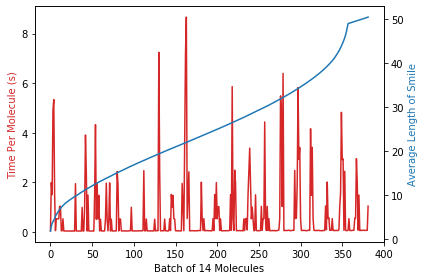

In [36]:
fig,ax1=plt.subplots()
color='tab:red'
ax1.set_xlabel('Batch of 14 Molecules')
ax1.set_ylabel('Time Per Molecule (s)',color=color)
ax1.plot(xs,times,color=color)

ax2=ax1.twinx()
color='tab:blue'
ax2.set_ylabel('Average Length of Smile',color=color)
ax2.plot(xs,lens,color=color)

fig.tight_layout()
plt.show()

In [37]:
data[-1]

(14.484168291091919, 14.008802890777588, 50.494191049913944)

In [38]:
data[-2]

(0.8281316757202148, 0.3655881881713867, 50.42964392964393)

In [43]:
sorted_smis[xs[-2]*14:xs[-2]*14+14]

['CNC(CC1=CC(O)=C(O)C=C1)C(=O)O',
 'O=C(O)CNC(CC1=CC=CC=C1)C(=O)O',
 'CCCCCOC(=O)C1=CC(Cl)=C(O)C=C1',
 'CCCCCOC(=O)C1=CC(Br)=C(O)C=C1',
 'CCCCCCOC(=O)C1=CC(I)=C(O)C=C1',
 'CS(=O)(=O)C1=CC=C(C(=N)N)C=C1',
 'CCN(CC)NC(=O)NC1=C(C)C=CC=C1C',
 'CCCN(C)N=NC1=CC=C(C(=O)O)C=C1',
 'O=C(O)CC(CSC(=O)O)C1=CC=CC=C1',
 'NC1=NC2=C(C=N1)N=CN2CCC(CO)CO',
 'C=CC1(CC(C)C)C(=O)NC(=O)NC1=O',
 'CCCC(C)C1(CC)C(=O)NC(=O)NC1=O',
 'O=C1NC(=O)C(Cl)=C(CN2CCCC2)N1',
 'O=C1NC(=O)C(Br)=C(CN2CCCC2)N1']

In [42]:
sorted_smis[xs[-1]*14:xs[-1]*14+14]

['O2c1ccccc1N(CC)C(=O)c3ccccc23',
 'CC(C(O)=O)c1cccc(Oc2ccccc2)c1',
 'c1ccc(cc1)\\N=N\\c1c(nc(cc1)N)N',
 'CC(C)NCC(O)COc1cccc2[nH]ccc12',
 'CC1(C)[C@H]2CC=C(CCO)[C@@H]1C2',
 'CC1(C)CC(CC(C)(CN=C=O)C1)N=C=O',
 'COc1ccc(\\C=C\\C(=O)OCCC(C)C)cc1',
 'CCCCOC(=O)c1ccc(cc1)C(=O)OCCCC',
 '[Co++].CCC([O-])=O.CCC([O-])=O',
 'CCCCCCCC\\C=C/CCCCCCCCNCCCNCCCN',
 'COc1cc(C=O)cc(c1O)[N+]([O-])=O',
 'OC(=O)Cc1ccccc1Nc2c(Cl)cccc2Cl',
 '[Br-].CCCC[N+](CCCC)(CCCC)CCCC',
 'Cc1ccccc1NC(=O)c2cc3ccccc3cc2O']

In [44]:
data[:2]

[(0.5469679832458496, 0.022916078567504883, 1.8571428571428572),
 (27.836974143981934, 27.300907135009766, 3.0)]

In [17]:
sorted_smis[0:14]

['N',
 'S',
 'C',
 'NO',
 'CF',
 'CC',
 'OO',
 'CI',
 'CN',
 'CS',
 'CO',
 'NN',
 'II',
 'CCS']

In [46]:
sorted_smis[14:28]

['CCO',
 'CSC',
 'COC',
 'FCF',
 'C#C',
 '[Y]',
 'B#N',
 '[V]',
 'CNN',
 '[P]',
 '[B]',
 'C#N',
 'CCN',
 'CCF']

In [18]:
complex_measure(cpu_model,sorted_smis[0:1])

(0.03748202323913574, 0.004896640777587891)

In [26]:
data2=[]
for i in tqdm(range(len(sorted_smis))):
    t,l=complex_measure(cpu_model,sorted_smis[i:i+1])
    al=get_mean_len(sorted_smis[i:i+1])
    data2.append((t,l,al))

  0%|          | 18/9982 [00:00<07:10, 23.14it/s]RDKit ERROR: [13:34:46] UFFTYPER: Unrecognized atom type: Y_2 (0)
RDKit ERROR: [13:34:53] UFFTYPER: Unrecognized atom type: Y_2 (0)
RDKit ERROR: [13:34:53] UFFTYPER: Unrecognized atom type: B_ (0)
RDKit ERROR: [13:34:53] UFFTYPER: Unrecognized atom type: B_ (0)
  0%|          | 21/9982 [00:07<2:00:40,  1.38it/s]RDKit ERROR: [13:34:53] UFFTYPER: Unrecognized atom type: V_3 (0)
RDKit ERROR: [13:35:00] UFFTYPER: Unrecognized atom type: V_3 (0)
  0%|          | 23/9982 [00:14<4:12:23,  1.52s/it]RDKit ERROR: [13:35:00] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:35:07] UFFTYPER: Unrecognized charge state for atom: 0
  0%|          | 37/9982 [00:28<2:07:48,  1.30it/s]RDKit ERROR: [13:35:14] UFFTYPER: Unrecognized atom type: Mo3 (0)
RDKit ERROR: [13:35:21] UFFTYPER: Unrecognized atom type: Mo3 (0)
  0%|          | 39/9982 [00:35<4:24:13,  1.59s/it]RDKit ERROR: [13:35:21] UFFTYPER: Unrecognized atom type: Re3 (0)
RDKit ERROR

  2%|▏         | 150/9982 [04:01<1:16:47,  2.13it/s]RDKit ERROR: [13:38:47] UFFTYPER: Unrecognized atom type: Zn+2 (1)
RDKit ERROR: [13:38:47] UFFTYPER: Unrecognized atom type: Zn+2 (1)
RDKit ERROR: [13:38:47] UFFTYPER: Unrecognized atom type: Sr (1)
RDKit ERROR: [13:38:47] UFFTYPER: Unrecognized atom type: Sr (1)
  2%|▏         | 153/9982 [04:01<55:40,  2.94it/s]  RDKit ERROR: [13:38:47] UFFTYPER: Unrecognized atom type: Mn3 (0)
RDKit ERROR: [13:38:54] UFFTYPER: Unrecognized atom type: Mn3 (1)
  2%|▏         | 159/9982 [04:08<1:48:54,  1.50it/s]RDKit ERROR: [13:38:54] UFFTYPER: Unrecognized atom type: Ni5 (0)
RDKit ERROR: [13:39:01] UFFTYPER: Unrecognized atom type: Ni5 (1)
  2%|▏         | 162/9982 [04:15<3:07:51,  1.15s/it]RDKit ERROR: [13:39:01] UFFTYPER: Unrecognized atom type: Fe3 (1)
RDKit ERROR: [13:39:01] UFFTYPER: Unrecognized atom type: Fe3 (1)
RDKit ERROR: [13:39:01] UFFTYPER: Unrecognized atom type: Ni5 (1)
RDKit ERROR: [13:39:01] UFFTYPER: Unrecognized atom type: Ni5 (1)


 10%|▉         | 992/9982 [11:00<1:53:09,  1.32it/s]RDKit WARNING: [13:45:46] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [13:45:46] UFFTYPER: Unrecognized charge state for atom: 2
RDKit WARNING: [13:45:46] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [13:45:46] UFFTYPER: Unrecognized charge state for atom: 2
 10%|▉         | 995/9982 [11:00<1:20:51,  1.85it/s]RDKit ERROR: [13:45:46] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:45:53] UFFTYPER: Unrecognized atom type: Co3 (0)
RDKit ERROR: [13:46:00] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:46:00] UFFTYPER: Unrecognized atom type: Co3 (1)
 10%|▉         | 995/9982 [11:20<1:20:51,  1.85it/s]RDKit ERROR: [13:46:07] UFFTYPER: Unrecognized atom type: Pd3 (0)
RDKit ERROR: [13:46:13] UFFTYPER: Unrecognized atom type: Pd3 (1)
 11%|█         | 1117/9982 [11:39<05:56, 24.88it/s]  RDKit ERROR: [13:46:25] UFFTYPER: Unrecognized atom type: Ca1 (0)
RDKit ERROR

 22%|██▏       | 2222/9982 [18:37<4:21:00,  2.02s/it]RDKit ERROR: [13:53:23] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:53:23] UFFTYPER: Unrecognized atom type: Zn+2 (0)
RDKit ERROR: [13:53:30] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [13:53:30] UFFTYPER: Unrecognized atom type: Zn+2 (2)
 22%|██▏       | 2224/9982 [18:44<5:15:59,  2.44s/it]RDKit ERROR: [13:53:30] UFFTYPER: Unrecognized atom type: Ba (0)
RDKit ERROR: [13:53:37] UFFTYPER: Unrecognized atom type: Ba (0)
 22%|██▏       | 2239/9982 [18:52<57:33,  2.24it/s]  RDKit ERROR: [13:53:38] UFFTYPER: Unrecognized atom type: Zr (0)
RDKit ERROR: [13:53:44] UFFTYPER: Unrecognized atom type: Zr (0)
 23%|██▎       | 2255/9982 [18:59<34:14,  3.76it/s]  RDKit WARNING: [13:53:52] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [13:53:52] UFFTYPER: Warning: hybridization set to SP3 for atom 2
 23%|██▎       | 2257/9982 [19:06<2:37:10,  1.22s/it]RDKit WARNING: [13:53:52] UFFTYPER:

 28%|██▊       | 2767/9982 [25:49<07:42, 15.61it/s]  RDKit ERROR: [14:00:35] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [14:00:35] UFFTYPER: Unrecognized atom type: Cd+2 (0)
RDKit ERROR: [14:00:42] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [14:00:42] UFFTYPER: Unrecognized atom type: Cd+2 (0)
 28%|██▊       | 2769/9982 [25:56<2:10:30,  1.09s/it]RDKit WARNING: [14:00:42] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [14:00:42] UFFTYPER: Unrecognized charge state for atom: 0
RDKit WARNING: [14:00:48] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [14:00:48] UFFTYPER: Unrecognized charge state for atom: 0
 28%|██▊       | 2774/9982 [26:09<4:36:28,  2.30s/it]RDKit ERROR: [14:00:55] UFFTYPER: Unrecognized atom type: Ti2 (1)
RDKit ERROR: [14:00:55] UFFTYPER: Unrecognized atom type: Ti2 (6)
 28%|██▊       | 2822/9982 [26:52<34:05,  3.50it/s]  RDKit ERROR: [14:01:38] UFFTYPER: Unrecognized atom type: Ca (0)
RDKit E

 36%|███▌      | 3550/9982 [34:09<06:47, 15.80it/s]   RDKit ERROR: [14:08:55] UFFTYPER: Unrecognized atom type: Ca (0)
RDKit WARNING: [14:09:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [14:09:02] UFFTYPER: Unrecognized atom type: Ca (0)
RDKit WARNING: [14:09:02] UFFTYPER: Warning: hybridization set to SP3 for atom 2
 36%|███▌      | 3552/9982 [34:16<2:00:31,  1.12s/it]RDKit WARNING: [14:09:03] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [14:09:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [14:09:03] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
RDKit WARNING: [14:09:09] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [14:09:09] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [14:09:09] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [14:09:09] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
RDKit WARNING: [14:09:09] UFFTYPER: Warning: hybridization set to SP3 for atom

 52%|█████▏    | 5144/9982 [53:30<16:30,  4.88it/s]  RDKit ERROR: [14:28:17] UFFTYPER: Unrecognized atom type: Y_ (0)
RDKit ERROR: [14:28:24] UFFTYPER: Unrecognized atom type: Y_ (0)
RDKit ERROR: [14:28:30] UFFTYPER: Unrecognized atom type: Y_ (3)
RDKit ERROR: [14:28:30] UFFTYPER: Unrecognized atom type: Y_ (4)
 52%|█████▏    | 5153/9982 [53:52<4:15:57,  3.18s/it] RDKit ERROR: [14:28:44] UFFTYPER: Unrecognized atom type: Fe3 (0)
RDKit ERROR: [14:28:51] UFFTYPER: Unrecognized atom type: Fe3 (1)
 52%|█████▏    | 5156/9982 [54:06<5:59:09,  4.47s/it]RDKit WARNING: [14:28:52] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:29:05] WARNING: not removing hydrogen atom without neighbors
 52%|█████▏    | 5184/9982 [54:21<10:27,  7.64it/s]  RDKit WARNING: [14:29:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:29:21] WARNING: not removing hydrogen atom without neighbors
 54%|█████▎    | 5342/9982 [54:52<05:46, 13.41it/s]  RDKit ERROR: [14:29:38

RDKit ERROR: [14:37:56] UFFTYPER: Unrecognized atom type: Ti (0)
RDKit ERROR: [14:38:03] UFFTYPER: Unrecognized atom type: Ca (3)
RDKit ERROR: [14:38:03] UFFTYPER: Unrecognized atom type: Ti (4)
 56%|█████▋    | 5633/9982 [1:03:52<8:48:11,  7.29s/it] RDKit ERROR: [14:38:58] UFFTYPER: Unrecognized atom type: Fe3 (0)
RDKit ERROR: [14:39:05] UFFTYPER: Unrecognized atom type: Fe3 (0)
RDKit ERROR: [14:39:12] UFFTYPER: Unrecognized atom type: Fe3 (3)
RDKit ERROR: [14:39:12] UFFTYPER: Unrecognized atom type: Fe3 (4)
 56%|█████▋    | 5638/9982 [1:04:46<12:09:56, 10.08s/it]RDKit ERROR: [14:39:53] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [14:39:53] UFFTYPER: Unrecognized atom type: As1+3 (0)
RDKit ERROR: [14:39:59] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [14:39:59] UFFTYPER: Unrecognized atom type: As1+3 (0)
RDKit ERROR: [14:40:06] UFFTYPER: Unrecognized charge state for atom: 3
RDKit ERROR: [14:40:06] UFFTYPER: Unrecognized atom type: As1+3 (3)
RDKit ERR

 63%|██████▎   | 6282/9982 [1:16:39<3:23:55,  3.31s/it]RDKit ERROR: [14:51:25] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [14:51:25] UFFTYPER: Unrecognized atom type: Zn+2 (0)
RDKit ERROR: [14:51:31] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [14:51:31] UFFTYPER: Unrecognized atom type: Zn+2 (0)
 65%|██████▍   | 6487/9982 [1:17:51<46:40,  1.25it/s]  RDKit WARNING: [14:52:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:52:50] WARNING: not removing hydrogen atom without neighbors
 65%|██████▌   | 6501/9982 [1:18:46<3:08:59,  3.26s/it]RDKit WARNING: [14:53:31] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:53:45] WARNING: not removing hydrogen atom without neighbors
 65%|██████▌   | 6518/9982 [1:19:00<18:35,  3.11it/s]  RDKit WARNING: [14:53:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:53:59] WARNING: not removing hydrogen atom without neighbors
 66%|██████▋   | 6620/

 77%|███████▋  | 7659/9982 [1:38:17<24:24,  1.59it/s]  RDKit ERROR: [15:13:03] UFFTYPER: Unrecognized atom type: Cu3 (0)
RDKit ERROR: [15:13:09] UFFTYPER: Unrecognized atom type: Cu3 (0)
 78%|███████▊  | 7758/9982 [1:38:32<03:56,  9.38it/s]  RDKit WARNING: [15:13:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:13:31] WARNING: not removing hydrogen atom without neighbors
 79%|███████▉  | 7891/9982 [1:39:31<29:32,  1.18it/s]  RDKit ERROR: [15:14:17] UFFTYPER: Unrecognized atom type: Fe3 (0)
RDKit ERROR: [15:14:24] UFFTYPER: Unrecognized atom type: Fe3 (1)
 79%|███████▉  | 7897/9982 [1:39:38<22:59,  1.51it/s]RDKit WARNING: [15:14:24] UFFTYPER: Warning: hybridization set to SP3 for atom 20
RDKit WARNING: [15:14:24] UFFTYPER: Warning: hybridization set to SP3 for atom 20
 79%|███████▉  | 7899/9982 [1:39:39<16:08,  2.15it/s]RDKit ERROR: [15:14:25] UFFTYPER: Unrecognized atom type: Ca (0)
RDKit ERROR: [15:14:32] UFFTYPER: Unrecognized atom type: Ca (0)
 79%|██████

RDKit ERROR: [15:21:42] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:21:42] UFFTYPER: Unrecognized atom type: Zn+2 (0)
 85%|████████▌ | 8513/9982 [1:46:56<1:08:33,  2.80s/it]RDKit ERROR: [15:22:15] UFFTYPER: Unrecognized atom type: Ti (0)
RDKit ERROR: [15:22:22] UFFTYPER: Unrecognized atom type: Zr (0)
RDKit WARNING: [15:22:28] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [15:22:28] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:22:28] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
RDKit ERROR: [15:22:35] UFFTYPER: Unrecognized atom type: Ti (5)
RDKit ERROR: [15:22:35] UFFTYPER: Unrecognized atom type: Zr (6)
RDKit WARNING: [15:22:35] UFFTYPER: Warning: hybridization set to SP3 for atom 7
RDKit ERROR: [15:22:35] UFFTYPER: Unrecognized charge state for atom: 7
RDKit ERROR: [15:22:35] UFFTYPER: Unrecognized atom type: Pb3+3 (7)
 85%|████████▌ | 8514/9982 [1:47:49<7:19:27, 17.96s/it]RDKit WARNING: [15:22:35] WARNING: not removing h

RDKit ERROR: [15:31:41] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:31:41] UFFTYPER: Unrecognized atom type: Ce+3 (0)
RDKit ERROR: [15:31:47] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:31:47] UFFTYPER: Unrecognized atom type: Ce+3 (0)
RDKit ERROR: [15:31:47] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:31:47] UFFTYPER: Unrecognized atom type: Ce+3 (1)
 89%|████████▉ | 8884/9982 [1:57:02<2:06:28,  6.91s/it]RDKit ERROR: [15:31:48] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:31:48] UFFTYPER: Unrecognized atom type: Nd+3 (0)
RDKit ERROR: [15:31:54] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:31:54] UFFTYPER: Unrecognized atom type: Nd+3 (0)
RDKit ERROR: [15:32:01] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:32:01] UFFTYPER: Unrecognized atom type: Nd+3 (0)
RDKit ERROR: [15:32:01] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:32:01] UFFTYPER: Unrec

 91%|█████████▏| 9122/9982 [2:06:27<02:39,  5.39it/s]  RDKit WARNING: [15:41:13] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [15:41:13] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:41:13] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
RDKit WARNING: [15:41:20] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [15:41:20] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:41:20] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
 91%|█████████▏| 9122/9982 [2:06:40<02:39,  5.39it/s]RDKit WARNING: [15:41:26] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [15:41:26] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:41:26] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
RDKit WARNING: [15:41:33] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [15:41:33] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [15:41:33] UFFTYPER: Unrecognized atom type: Pb3+3 (2)
RDKit WA

 94%|█████████▍| 9426/9982 [2:20:58<1:44:32, 11.28s/it]RDKit ERROR: [15:55:44] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:55:44] UFFTYPER: Unrecognized atom type: Gd3+3 (0)
RDKit ERROR: [15:55:51] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:55:51] UFFTYPER: Unrecognized atom type: Gd3+3 (0)
RDKit ERROR: [15:55:58] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [15:55:58] UFFTYPER: Unrecognized atom type: Gd3+3 (0)
RDKit ERROR: [15:55:58] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:55:58] UFFTYPER: Unrecognized atom type: Gd3+3 (1)
 94%|█████████▍| 9427/9982 [2:21:12<1:50:34, 11.95s/it]RDKit ERROR: [15:55:58] UFFTYPER: Unrecognized atom type: Ca (0)
RDKit ERROR: [15:56:05] UFFTYPER: Unrecognized atom type: Ca (0)
 94%|█████████▍| 9428/9982 [2:21:19<1:36:10, 10.42s/it]RDKit ERROR: [15:56:05] UFFTYPER: Unrecognized atom type: Ba (0)
RDKit ERROR: [15:56:12] UFFTYPER: Unrecognized atom type: Ba (0)
 95%|█████████▍

RDKit WARNING: [16:07:32] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [16:07:32] UFFTYPER: Unrecognized charge state for atom: 0
RDKit WARNING: [16:07:39] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [16:07:39] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [16:07:39] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [16:07:39] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [16:07:39] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [16:07:39] UFFTYPER: Unrecognized charge state for atom: 0
RDKit WARNING: [16:07:39] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [16:07:39] UFFTYPER: Unrecognized charge state for atom: 1
RDKit WARNING: [16:07:39] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [16:07:39] UFFTYPER: Unrecognized charge state for atom: 2
RDKit WARNING: [16:07:39] UFFTYPER: Warning: hybridization set t

RDKit ERROR: [16:47:33] UFFTYPER: Unrecognized atom type: Ca (0)
RDKit ERROR: [16:47:39] UFFTYPER: Unrecognized atom type: Ca (0)
RDKit WARNING: [16:47:46] UFFTYPER: Warning: hybridization set to SP3 for atom 6
RDKit ERROR: [16:47:46] UFFTYPER: Unrecognized charge state for atom: 6
RDKit WARNING: [16:47:46] UFFTYPER: Warning: hybridization set to SP3 for atom 7
RDKit ERROR: [16:47:46] UFFTYPER: Unrecognized charge state for atom: 7
RDKit ERROR: [16:47:46] UFFTYPER: Unrecognized atom type: Ca (8)
RDKit ERROR: [16:47:46] UFFTYPER: Unrecognized atom type: Ca (9)
RDKit ERROR: [16:47:46] UFFTYPER: Unrecognized atom type: Ca (10)
RDKit ERROR: [16:47:46] UFFTYPER: Unrecognized atom type: Ca (11)
RDKit ERROR: [16:47:46] UFFTYPER: Unrecognized atom type: Ca (12)
RDKit ERROR: [16:47:46] UFFTYPER: Unrecognized atom type: Ca (13)
 99%|█████████▉| 9910/9982 [3:14:44<23:32, 19.62s/it]RDKit ERROR: [16:49:50] UFFTYPER: Unrecognized atom type: Cr2 (0)
RDKit ERROR: [16:49:57] UFFTYPER: Unrecognized atom

RDKit ERROR: [17:16:24] UFFTYPER: Unrecognized atom type: Cr3 (2)
RDKit ERROR: [17:16:24] UFFTYPER: Unrecognized atom type: Cr3 (3)
100%|█████████▉| 9971/9982 [3:42:20<04:49, 26.30s/it]RDKit WARNING: [17:17:06] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [17:17:06] UFFTYPER: Unrecognized charge state for atom: 0
RDKit WARNING: [17:17:13] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [17:17:13] UFFTYPER: Unrecognized charge state for atom: 0
RDKit WARNING: [17:17:20] UFFTYPER: Warning: hybridization set to SP3 for atom 0
RDKit ERROR: [17:17:20] UFFTYPER: Unrecognized charge state for atom: 0
RDKit WARNING: [17:17:20] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [17:17:20] UFFTYPER: Unrecognized charge state for atom: 1
100%|██████████| 9982/9982 [3:47:14<00:00,  1.37s/it]


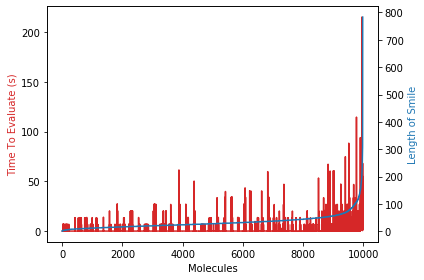

In [27]:
xs=list(range(len(data2)))
fig,ax1=plt.subplots()
color='tab:red'
ax1.set_xlabel('Molecules')
ax1.set_ylabel('Time To Evaluate (s)',color=color)
ax1.plot(xs,[x for x,y,z in data2],color=color)

ax2=ax1.twinx()
color='tab:blue'
ax2.set_ylabel('Length of Smile',color=color)
ax2.plot(xs,[z for x,y,z in data2],color=color)

fig.tight_layout()
plt.show()

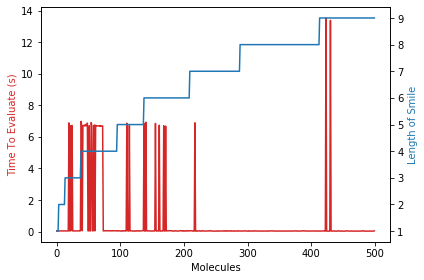

In [35]:
fig,ax1=plt.subplots()
color='tab:red'
ax1.set_xlabel('Molecules')
ax1.set_ylabel('Time To Evaluate (s)',color=color)
ax1.plot(xs[:500],[x for x,y,z in data2][:500],color=color)

ax2=ax1.twinx()
color='tab:blue'
ax2.set_ylabel('Length of Smile',color=color)
ax2.plot(xs[:500],[z for x,y,z in data2][:500],color=color)

fig.tight_layout()
plt.show()

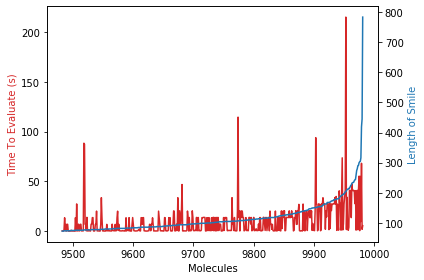

In [36]:
fig,ax1=plt.subplots()
color='tab:red'
ax1.set_xlabel('Molecules')
ax1.set_ylabel('Time To Evaluate (s)',color=color)
ax1.plot(xs[-500:],[x for x,y,z in data2][-500:],color=color)

ax2=ax1.twinx()
color='tab:blue'
ax2.set_ylabel('Length of Smile',color=color)
ax2.plot(xs[-500:],[z for x,y,z in data2][-500:],color=color)

fig.tight_layout()
plt.show()

In [28]:
def printer(index, data_first=data2,data_second=sorted_smis):
    return(data_first[index],data_second[index])

In [42]:
import pickle
pickle.dump(data2,open('individ_fp_rawdata.pi','wb'))

In [47]:
more1s_count=0
and_chiral=0
and_period=0
and_brace=0
for i in range(len(data2)):
    items,smile=printer(i)
    if items[0] > 1:
        more1s_count+=1
        if '[' in smile:
            and_brace+=1
        if '.' in smile:
            and_period+=1
        if '@' in smile:
            and_chiral+=1
        
        if '[' not in smile and '.' not in smile and '@' not in smile:
            print(len(smile),smile,items[1])
print('Number took >1s:',more1s_count)
print('Had period in smile:',and_period)
print('Had braces in smile:',and_brace)
print('Chiral:',and_chiral)

24 C1Cc2ccc(CCc3ccc1cc3)cc2 61.35334348678589
26 CC(C)C1CC2=C(C)CC1C(C2)C=O 50.165940284729004
39 ClC1=CC=C(C=C1)N2N=NC3C4CC(C5N=NC45)C23 2.8146378993988037
49 CCCCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCCCCCCCCCC 0.9561443328857422
53 CCCCCCCCCCCCCCCCCCNC(=O)NCCCNC(=O)NCCCCCCCCCCCCCCCCCC 0.9638848304748535
64 CCCCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCC(=O)OCCCCCCCCCCCCCCCCCCCCCC 1.2925701141357422
65 CCCCCCCCCCCCCCCCCCCCCC(=O)OCC(CO)(CO)COC(=O)CCCCCCCCCCCCCCCCCCCCC 0.9924275875091553
66 CCCCCCCCCCCCCCCCCC(=O)OC(CCCCCC)CCCCCCCCCCC(=O)OCCCCCCCCCCCCCC(C)C 1.3326895236968994
71 CCCCCCCCCCCCCCCCCCNC(=O)Nc1ccc(Cc2ccc(NC(=O)NCCCCCCCCCCCCCCCCCC)cc2)cc1 1.1768701076507568
74 CCCCCCCCCCCCCCCCCC(=O)OCC(COC(=O)CCCCCCCCCCCCCCCCC)OC(=O)CCCCCCCCCCCCCCCCC 1.2896027565002441
77 CCCCCCCCCCCCCCCCCCC1CC(=O)N(CCNCCNCCNCCN2C(=O)CC(CCCCCCCCCCCCCCCCCC)C2=O)C1=O 1.341170072555542
80 CC(C)CCCCCCCCCCCCCCC(=O)OCC(COC(=O)CCCCCCCCCCCCCCC(C)C)OC(=O)CCCCCCCCCCCCCCC(C)C 1.3078598976135254
83 CCCCCCC(O)CCCCCCCCCCC(=O)OCC(COC(=O

In [39]:
more1s_count=0
and_chiral=0
and_period=0
and_brace=0
for i in range(len(data2)):
    items,smile=printer(i)
    if '[' in smile:
        more1s_count+=1
        if items[0] >1:
            and_brace+=1
        if '.' in smile:
            and_period+=1
        if '@' in smile:
            and_chiral+=1
print('Had braces:',more1s_count)
print('Had period in smile:',and_period)
print('Took >1s:',and_brace)
print('Chiral:',and_chiral)

Had braces: 3091
Had period in smile: 990
Took >1s: 932
Chiral: 467


In [40]:
more1s_count=0
and_chiral=0
and_period=0
and_brace=0
for i in range(len(data2)):
    items,smile=printer(i)
    if '@' in smile:
        more1s_count+=1
        if '[' in smile:
            and_brace+=1
        if '.' in smile:
            and_period+=1
        if items[0]>1:
            and_chiral+=1
print('Chiral:',more1s_count)
print('Had period in smile:',and_period)
print('Had braces in smile:',and_brace)
print('Took >1s:',and_chiral)

Chiral: 467
Had period in smile: 37
Had braces in smile: 467
Took >1s: 32


In [49]:
more1s_count=0
and_chiral=0
and_period=0
and_brace=0
brace_1s_combo=0
for i in range(len(data2)):
    items,smile=printer(i)
    if '.' in smile:
        more1s_count+=1
        if '[' in smile:
            and_brace+=1
        if items[0] >1:
            and_period+=1
        if '@'in smile:
            and_chiral+=1
        
        if items[0] >1 and '[' in smile:
            brace_1s_combo+=1
print('Had period in smile:',more1s_count)
print('Took >1s',and_period)
print('Had braces in smile:',and_brace)
print('Chiral:',and_chiral)
print('took >1s and braces:',brace_1s_combo)

Had period in smile: 1098
Took >1s 897
Had braces in smile: 990
Chiral: 37
took >1s and braces: 889


# Looking at results from 2D only models

In [41]:
import pickle
import numpy as np

In [3]:
import glob

In [14]:
import re

In [43]:
aq=[float(x.split(',')[1]) for x in open('data/aqsol/aqsol.csv').readlines()[1:]]
np.max(aq),np.min(aq)

(2.1376816201, -13.1719)

In [4]:
pt_files=glob.glob('figs/*')

In [5]:
pt_files.sort()
pt_files

['figs/cv_rand_sgd_2d_defaults_0_testdic.pi',
 'figs/cv_rand_sgd_2d_defaults_0_trainepochlosses.pi',
 'figs/cv_rand_sgd_2d_defaults_0_trainlosses.pi',
 'figs/cv_rand_sgd_2d_defaults_1_testdic.pi',
 'figs/cv_rand_sgd_2d_defaults_1_trainepochlosses.pi',
 'figs/cv_rand_sgd_2d_defaults_1_trainlosses.pi',
 'figs/cv_rand_sgd_2d_defaults_2_testdic.pi',
 'figs/cv_rand_sgd_2d_defaults_2_trainepochlosses.pi',
 'figs/cv_rand_sgd_2d_defaults_2_trainlosses.pi',
 'figs/cv_scaf_sgd_2d_defaults_0_testdic.pi',
 'figs/cv_scaf_sgd_2d_defaults_0_trainepochlosses.pi',
 'figs/cv_scaf_sgd_2d_defaults_0_trainlosses.pi',
 'figs/cv_scaf_sgd_2d_defaults_1_testdic.pi',
 'figs/cv_scaf_sgd_2d_defaults_1_trainepochlosses.pi',
 'figs/cv_scaf_sgd_2d_defaults_1_trainlosses.pi',
 'figs/cv_scaf_sgd_2d_defaults_2_testdic.pi',
 'figs/cv_scaf_sgd_2d_defaults_2_trainepochlosses.pi',
 'figs/cv_scaf_sgd_2d_defaults_2_trainlosses.pi']

In [6]:
nopt_files=glob.glob('no_pretrain_figs/*')
nopt_files.sort()

In [7]:
#testing
data=pickle.load(open(pt_files[0],'rb'))

In [8]:
data

{'predicted': array([-3.86230588, -1.92644215,  0.2366827 , ..., -2.77505183,
        -1.71589315, -3.23398113]),
 'target': array([-3.80999994, -1.14127302,  0.4853    , ...,  0.71642292,
        -1.49909997, -2.88459992]),
 'RMSE': 0.01620447056942654,
 'R2': 0.7988038349853763}

In [48]:
def test_stat_print(listo):
    rmse=0
    r2=0
    count=0
    for dic in listo:
        count+=1
        r2+=dic['R2']
        rmse+=dic['RMSE']
    return(r2/float(count),rmse/float(count))

In [49]:
for datakey in ['pt','nopt']:
    if datakey=='pt':
        dataset=pt_files
    else:
        dataset=nopt_files
        
    for key in ['rand','scaf']:
        print(datakey,'--',key)
        datafiles=[pickle.load(open(x,'rb')) for x in dataset if key in x and 'testdic' in x]
        print(test_stat_print(datafiles))
        print('--------')

pt -- rand
(0.7967389001483514, 0.010872660044160744)
--------
pt -- scaf
(0.624075163002915, 0.1577386379662813)
--------
nopt -- rand
(0.7971997067108635, 0.05345947140190569)
--------
nopt -- scaf
(0.6075064436411776, 0.19318937964975955)
--------


In [12]:
data=pickle.load(open(pt_files[1],'rb'))
len(data)

500

In [38]:
data=pickle.load(open(pt_files[2],'rb'))
len(data)

6656.0

In [30]:
def epoch_plotter(listo_tups, last100=False):
    if last100:
        for data,title in listo_tups:
            plt.plot(range(len(data)-100,len(data)),data[-100:])
            plt.xlabel('Epoch')
            plt.ylabel('MSE Loss')
            plt.title(title)
            plt.show()
    else:
        for data,title in listo_tups:
            plt.plot(data)
            plt.xlabel('Epoch')
            plt.ylabel('MSE Loss')
            plt.title(title)
            plt.show()

In [32]:
pt_epoch_graph_data=[(pickle.load(open(x,'rb')),'2D -- Pretrained CV Fold: '+x.split('/cv_')[1][:4]+' '+re.search(r'_(\d)_t',x).group(1)) for x in [y for y in pt_files if 'epoch' in y]]

In [33]:
nopt_epoch_graph_data=[(pickle.load(open(x,'rb')),'2D -- NOT Pretrained CV Fold: '+x.split('/cv_')[1][:4]+' '+re.search(r'_(\d)_t',x).group(1)) for x in [y for y in nopt_files if 'epoch' in y]]

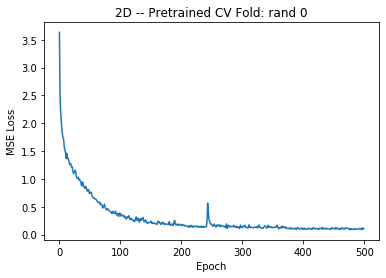

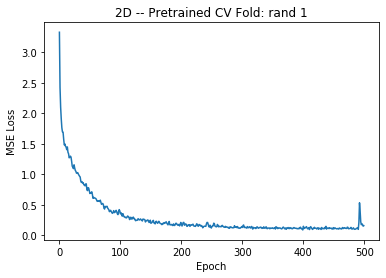

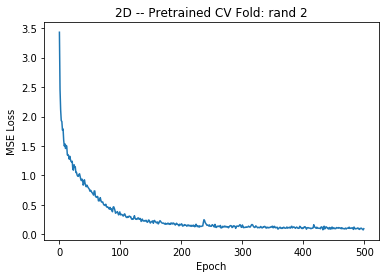

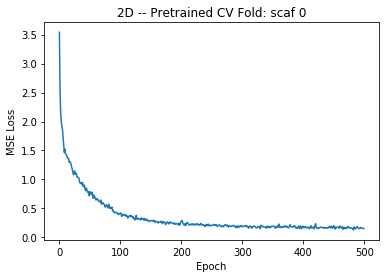

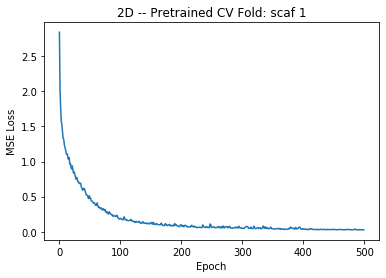

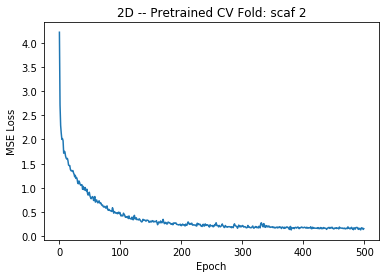

In [34]:
epoch_plotter(pt_epoch_graph_data)

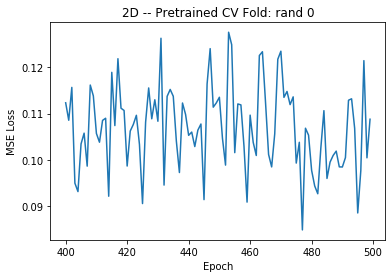

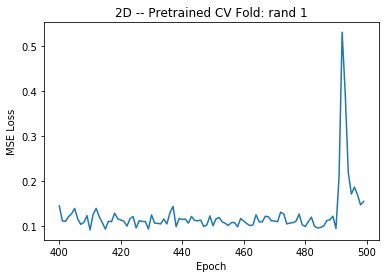

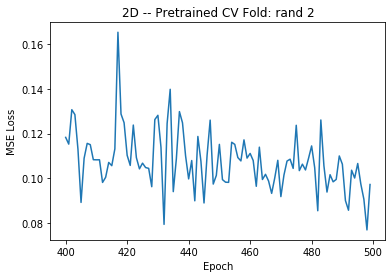

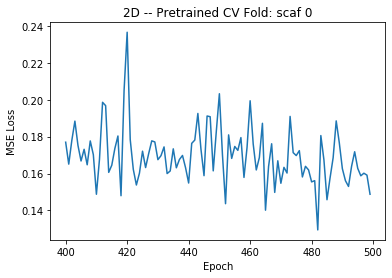

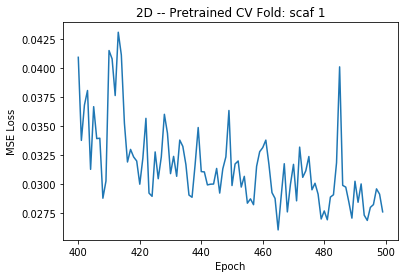

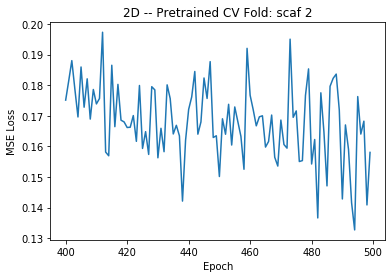

In [35]:
epoch_plotter(pt_epoch_graph_data,True)

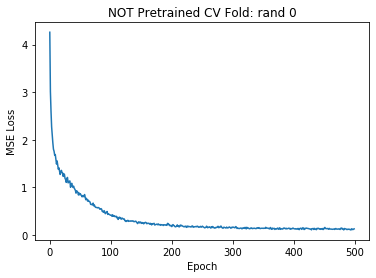

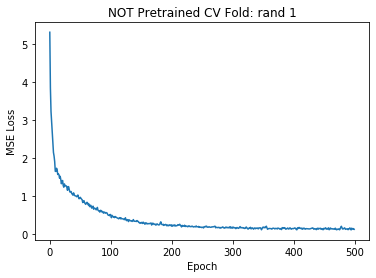

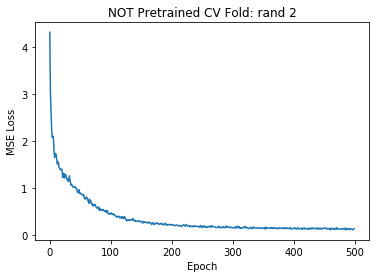

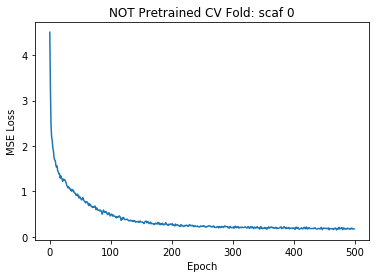

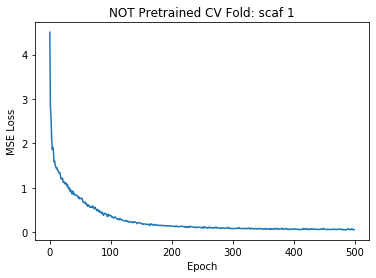

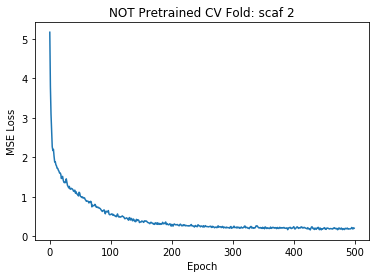

In [29]:
epoch_plotter(nopt_epoch_graph_data)

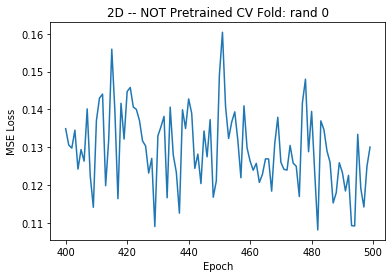

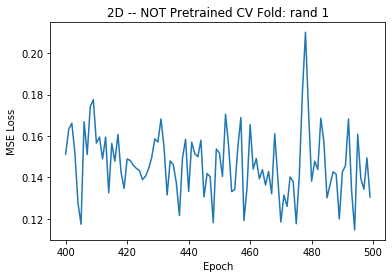

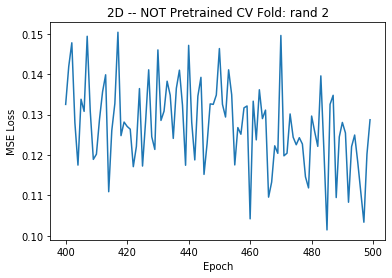

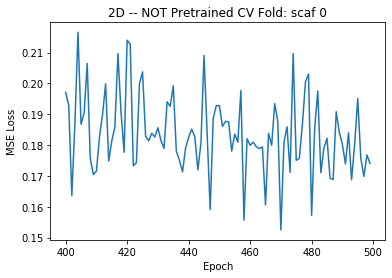

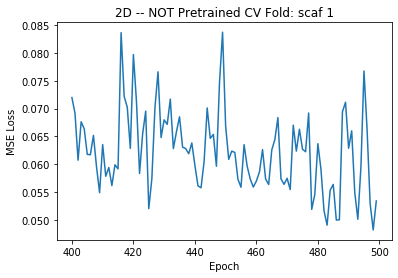

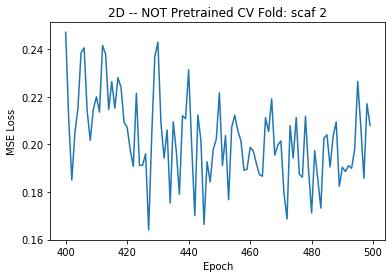

In [36]:
epoch_plotter(nopt_epoch_graph_data,True)

# Analyzing the independent test set

### Step 1:  Calculating fingerprints for each thing

In [3]:
new_files=[
    'data/esol/esol.csv',
    'data/freesolv/freesolv.csv',
    'data/sol_challenge/sol_challenge.csv',
    'data/sol_challenge/dls100.csv'
]

aqsol='data/aqsol/aqsol.csv'

In [4]:
import pandas as pd

In [5]:
a_data=pd.read_csv(aqsol)

In [6]:
a_fps=[Chem.RDKFingerprint(Chem.MolFromSmiles(x)) for x in a_data['smiles']]

RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:50:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:51:00] WARNING: not r

In [7]:
ind_fps={}#dictionary of filename -> [fingerprints]

for fname in new_files:
    key=fname.split('/')[-1].split('.csv')[0]
    data=pd.read_csv(fname)
    fps=[Chem.RDKFingerprint(Chem.MolFromSmiles(x)) for x in data['smiles']]
    ind_fps[key]=fps

## Step 2: Calculating the max Tanimoto histograms between each pair of datasets

In [8]:
def find_max_Tanimoto(fp1, list_o_fps):
    '''
    Function that calculates the tanimoto between fp1 and every fingerprint in list_o_fps, and returns the max
    '''
    
    max_tanimoto=-1
    
    for compare in list_o_fps:
        candidate=DataStructs.FingerprintSimilarity(fp1,compare)
        if candidate > max_tanimoto:
            max_tanimoto=candidate
        #print(max_tanimoto)
    
    return max_tanimoto

In [9]:
max_tanimotos={'esol':{},'freesolv':{},'sol_challenge':{},'dls100':{}} # dic dataset1->other_datasetname -> [max tanimoto]
for key1 in max_tanimotos.keys():
    #first we need to compare to the other independent datasets
    for key2 in ind_fps.keys():
        if key1 == key2:
            continue
        
        tms=[]
        for fp in ind_fps[key1]:
            tms.append(find_max_Tanimoto(fp,ind_fps[key2]))
        
        max_tanimotos[key1][key2]=tms
    
    #now we can add the comparison to aqsol
    aq_max_tms=[]
    for fp1 in ind_fps[key1]:
        aq_max_tms.append(find_max_Tanimoto(fp1,a_fps))
    max_tanimotos[key1]['aqsol']=aq_max_tms

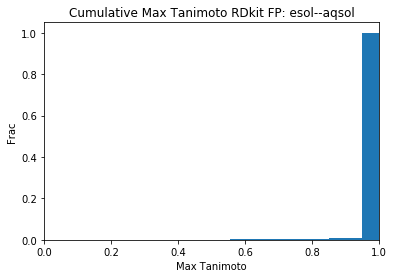

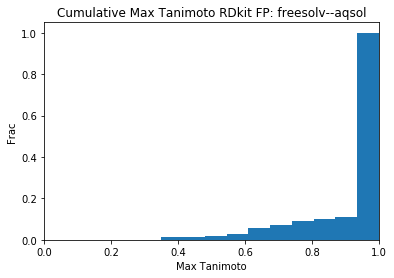

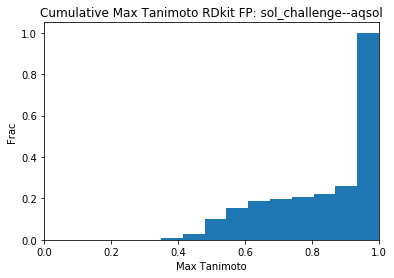

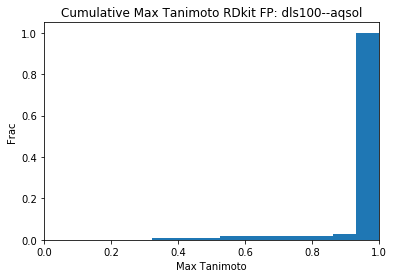

In [13]:
#plotting the cumulative tanimoto
for key1 in max_tanimotos.keys():
    for key2 in ['aqsol']:#max_tanimotos[key1].keys():
        fig=plt.figure()
        plt.hist(max_tanimotos[key1][key2],10,density=True,cumulative=True)
        plt.xlim((0,1))
        plt.title(f'Cumulative Max Tanimoto RDkit FP: {key1}--{key2}')
        plt.ylabel('Frac')
        plt.xlabel('Max Tanimoto')
        #plt.savefig(f'cum_tanimoto_{key1}_{key2}.png',dpi=200)

In [16]:
for key1 in max_tanimotos.keys():
    under_nine=len([x for x in max_tanimotos[key1]['aqsol'] if x<0.9])
    under_eight=len([x for x in max_tanimotos[key1]['aqsol'] if x<0.8])
    print(key1,len(max_tanimotos[key1][key2]), under_nine, under_eight)

esol 1128 9 7
freesolv 642 66 57
sol_challenge 132 31 27
dls100 100 3 2
